In [19]:

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import Adam
import pandas as pd

# Load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize to [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# Check shapes
print(x_train.shape)  # (50000, 32, 32, 3)
print(y_train.shape)  # (50000, 1)

# Optional: convert labels to one-hot
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)


(50000, 32, 32, 3)
(50000, 1)


In [10]:
def convolutional_model_forloop(input_shape):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE

    Arguments:
    input_shape -- shape of the input data, e.g. (32, 32, 3)

    Returns:
    model -- tf.keras.Model
    """

    input_img = tf.keras.Input(shape=input_shape)
    x = input_img

    # Layer configuration list: (filters, kernel_size, pool_size)
    layer_configs = [
        (16, (3, 3), (2, 2)),   # First Conv block
        (32, (3, 3), (2, 2)),  # Second Conv block
        (64, (3, 3), (2, 2))   # Third Conv block
    ]

    for filters, kernel_size, pool_size in layer_configs:
        x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)      # ← Add BatchNorm here
        x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.MaxPool2D(pool_size=pool_size, strides=pool_size, padding='same')(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.5)(x)  # Dropout with 50% rate
    outputs = tf.keras.layers.Dense(units=10, activation='softmax')(x)


    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model


In [20]:

conv_model = convolutional_model_forloop((32, 32, 3))

initial_lr = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=1000,         # How often to decay (depends on batch size)
    decay_rate=0.9,          # Multiplies LR by this every `decay_steps`
    staircase=False           # Smooth (False) or step-wise (True)
)

optimizer = Adam(learning_rate=lr_schedule)

conv_model.compile(optimizer=optimizer,
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])
conv_model.summary()
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 32, 32, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 32, 32, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_24 (ReLU)                      │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 16, 16, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 16, 16, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_25 (ReLU)                      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 8, 8, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_26 (ReLU)                      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,282 (133.91 KB)

 Trainable params: 34,058 (133.04 KB)

 Non-trainable params: 224 (896.00 B)

In [10]:
history = conv_model.fit(train_dataset, epochs=50, validation_data=test_dataset)

Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7705 - loss: 0.6567 - val_accuracy: 0.7819 - val_loss: 0.6355
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7686 - loss: 0.6531 - val_accuracy: 0.7845 - val_loss: 0.6304
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7700 - loss: 0.6570 - val_accuracy: 0.7853 - val_loss: 0.6302
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7679 - loss: 0.6578 - val_accuracy: 0.7852 - val_loss: 0.6301
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7730 - loss: 0.6542 - val_accuracy: 0.7843 - val_loss: 0.6293
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7690 - loss: 0.6552 - val_accuracy: 0.7844 - val_loss: 0.6304
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7716 - loss: 0.6501 - val_accuracy: 0.7833 - val_loss: 0.6291
Epoch 8/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7727 - loss: 0.6510 - val_accuracy: 0

<ipython-input-8-6ef75c355c13>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
<ipython-input-8-6ef75c355c13>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

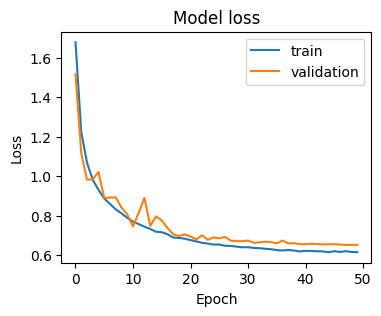

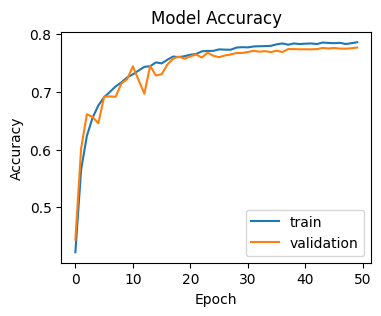

In [ ]:

# history.history
# The history.history["loss"] entry is a dictionary with as many values as epochs that the
# model was trained on.
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(4,3)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(4,3)).set(xlabel='Epoch',ylabel='Accuracy')

